In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import StratifiedKFold, train_test_split, HalvingGridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score,ConfusionMatrixDisplay,confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

Read the credit card dataset via pandas. The dataset was obtained via kaggle at this link: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [25]:
df = pd.read_csv('creditcard.csv')
X = df.iloc[:,:-1].to_numpy()
y = df.iloc[:,-1].to_numpy()
X_original = df.iloc[:,:-1].to_numpy()
y_original = df.iloc[:,-1].to_numpy()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Let's visualize the data imbalance with a scatterplot plotting two random features of each class

Counter({0: 284315, 1: 492})


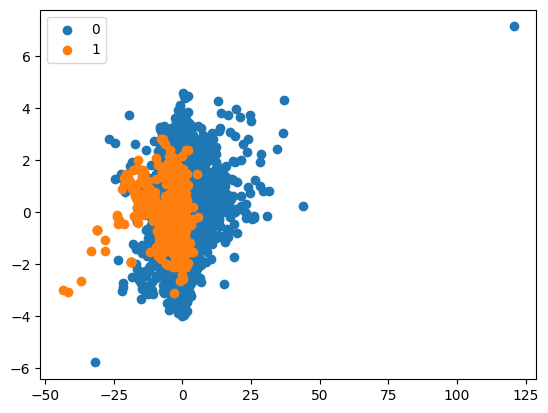

In [26]:
from numpy import where
counter = Counter(y)
print(counter)

for label,_ in counter.items():
    idx = where(y==label)[0]
    plt.scatter(X[idx,7], X[idx,13],label=str(label))

plt.legend()
plt.show()

Lets use Oversampling and Undersampling to Balance our dataset, we add over 25,000 new Fraudulent datapoints 

In [27]:
oversample = SMOTE(sampling_strategy=0.1)
X, y = oversample.fit_resample(X,y)
counter = Counter(y)
print(counter)

Counter({0: 284315, 1: 28431})


Now we have an equal amount of Fraudulent and Legitamite transactions on our Dataset, if we plot the same scatterplot, we can see there are now many more points of fraudulent data

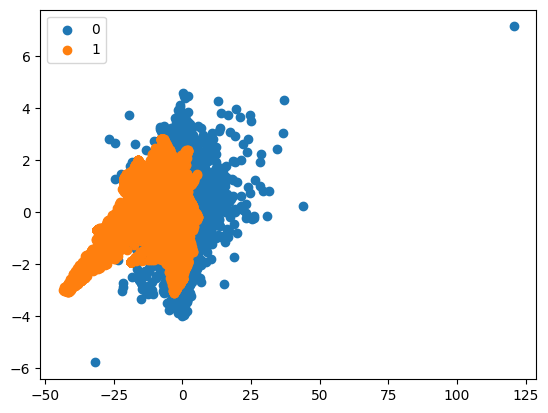

In [28]:
for label,_ in counter.items():
    idx = where(y==label)[0]
    plt.scatter(X[idx,7], X[idx,13],label=str(label))

plt.legend()
plt.show()

We will combine oversampling with undersampling of the majority class(Legitamite Transactions)

In [29]:
undersampler = RandomUnderSampler(sampling_strategy=0.5)

X_sampled,y_sampled = undersampler.fit_resample(X,y)
counter = Counter(y)
print(counter)

Counter({0: 284315, 1: 28431})


Now we have a more balanced dataset that a classification model can learn from

f1 score: 0.9982443820224719


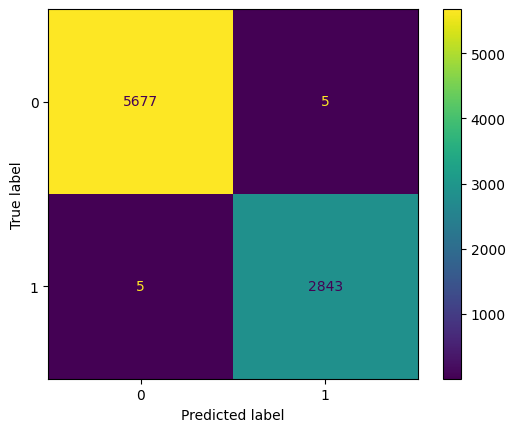

CPU times: total: 1min 9s
Wall time: 3.56 s


In [30]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X_sampled,y_sampled,test_size=0.1)

rfc = RandomForestClassifier(n_estimators=100,random_state=0,n_jobs=-1)
rfc.fit(X_train,y_train)
pred = rfc.predict(X_test)
print(f"f1 score: {f1_score(y_test,pred)}")

cm = confusion_matrix(y_test,pred,labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.show()

Our model seems to be working well with an f1 score above 0.99, a false negative rate below 0.01% and a False positive rate below 0.001%. Let's compare the model using over/under sampled data with the raw data to understand the performance difference. 

f1 score without sampling: 0.9069767441860466


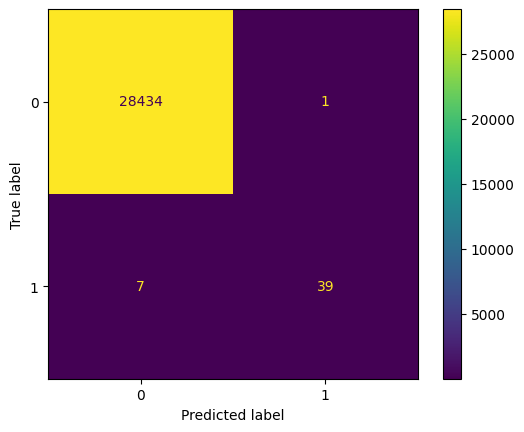

CPU times: total: 6min 36s
Wall time: 19.3 s


In [31]:
%%time
#print(X_original.shape,y_original.shape)

X_train, X_test, y_train, y_test = train_test_split(X_original,y_original,test_size=0.1)
#print(X_train.shape,X_test.shape)
#print(y_train.shape,y_test.shape)

rfc.fit(X_train,y_train)
pred = rfc.predict(X_test)
print(f"f1 score without sampling: {f1_score(y_test,pred)}")

cm = confusion_matrix(y_test,pred,labels=rfc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rfc.classes_)
disp.plot()
plt.show()

Without sampling, a much lower F1 score is observed. A score much too low to be acceptable for fraud detection as up to 40% false negative rate was observed during experimentation. Next lets tune the hyperparemeters of the Random Forest with Grid Search

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_sampled,y_sampled,test_size=0.1)

params = [
    {
        'n_estimators': [200,400,600,800,1000],
        'criterion': ['gini','entropy','log_loss'],
        'max_depth': [None,10,20,30,40,50,60,70,80,90,100],
        'max_features': ['auto','sqrt','log2'],
        'min_samples_leaf': [1,2,4],
        'min_samples_split': [2,5,10]
    }
]

rs_rf = RandomizedSearchCV(RandomForestClassifier(),param_distributions=params,scoring='f1',cv=5,n_jobs=-1)
rs_rf.fit(X_train,y_train)
print(rs_rf.best_params_)
print(rs_rf.best_score_)

{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'log_loss'}
0.9974315773280061


Now that we have obtained the ideal parameters, we can use these parameters in combination with K-Fold Cross Validation with 10 splits to ensure that our model will perform well outside of our specific test cases

In [34]:
%%time

# [insert ideal parameters below]
rfc = RandomForestClassifier(n_estimators=200,min_samples_split=2,min_samples_leaf=1,max_features='log2',max_depth=100,criterion='log_loss',n_jobs=-1)
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)

f1_scores = []

for train_idx,test_idx in skf.split(X_sampled,y_sampled):
    X_train_fold, X_test_fold = X_sampled[train_idx], X_sampled[test_idx]
    y_train_fold, y_test_fold = y_sampled[train_idx], y_sampled[test_idx]
    rfc.fit(X_train_fold,y_train_fold)
    pred = rfc.predict(X_test_fold)
    f1_scores.append(f1_score(y_test_fold,pred))

print(f1_scores)
print(f"Average f1 score: {sum(f1_scores) / len(f1_scores)}")

[0.998593035525853, 0.9985915492957745, 0.9975386779184248, 0.9994722955145119, 0.9970065152315548, 0.9982437653670531, 0.9982394366197184, 0.9977132805628848, 0.9980637211758494, 0.9970033491979552]
Average f1 score: 0.9980465626409579
CPU times: total: 16min 57s
Wall time: 47.1 s


Our average f1 score with the trained model is 0.998 which is extremely accurate, completeing a model that can successfully detect fraudulent transactions with high percision and recall 